**<h1>Aim: </h1>**
The aim of this notebook is to perform BBN on the given MonkeyPox Dataset

**Importing modules required for this project:**

In [116]:
import pandas as pd # for data manipulation 
import networkx as nx # for drawing graphs
import matplotlib.pyplot as plt # for drawing graphs
import io

In [117]:
pip install pybbn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [118]:
# for creating Bayesian Belief Networks (BBN)
from pybbn.graph.dag import Bbn
from pybbn.graph.edge import Edge, EdgeType
from pybbn.graph.jointree import EvidenceBuilder
from pybbn.graph.node import BbnNode
from pybbn.graph.variable import Variable
from pybbn.pptc.inferencecontroller import InferenceController

In [119]:
from google.colab import files
uploaded = files.upload()

Saving DATA.csv to DATA (3).csv


Reading the data into Pandas Dataframe: 

In [120]:
dataset = pd.read_csv(io.BytesIO(uploaded["DATA.csv"]))

<h1>Overview of the dataset: </h1>

In [121]:
dataset

,Patient_ID,Systemic Illness,Rectal Pain,Sore Throat,Penile Oedema,Oral Lesions,Solitary Lesion,Swollen Tonsils,HIV Infection,Sexually Transmitted Infection,MonkeyPox
0,P0,None,False,True,True,True,False,True,False,False,Negative
1,P1,Fever,True,False,True,True,False,False,True,False,Positive
2,P2,Fever,False,True,True,False,False,False,True,False,Positive
3,P3,None,True,False,False,False,True,True,True,False,Positive
4,P4,Swollen Lymph Nodes,True,True,True,False,False,True,True,False,Positive
...,...,...,...,...,...,...,...,...,...,...,...
24995,P24995,None,True,True,False,True,True,False,False,True,Positive
24996,P24996,Fever,False,True,True,False,True,True,True,True,Positive
24997,P24997,None,True,True,False,False,True,True,False,False,Positive
24998,P24998,Swollen Lymph Nodes,False,True,False,True,True,True,False,False,Negative


In [122]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   Patient_ID                      25000 non-null  object
 1   Systemic Illness                25000 non-null  object
 2   Rectal Pain                     25000 non-null  bool  
 3   Sore Throat                     25000 non-null  bool  
 4   Penile Oedema                   25000 non-null  bool  
 5   Oral Lesions                    25000 non-null  bool  
 6   Solitary Lesion                 25000 non-null  bool  
 7   Swollen Tonsils                 25000 non-null  bool  
 8   HIV Infection                   25000 non-null  bool  
 9   Sexually Transmitted Infection  25000 non-null  bool  
 10  MonkeyPox                       25000 non-null  object
dtypes: bool(8), object(3)
memory usage: 781.4+ KB


Function for calculating the Probablities: 

In [123]:
def probs(data, child, parent1=None, parent2=None):
    if parent1==None:
        # Calculate probabilities
        prob=pd.crosstab(data[child], 'Empty', margins=False, normalize='columns').sort_index().to_numpy().reshape(-1).tolist()
    elif parent1!=None:
            # Check if child node has 1 parent or 2 parents
            if parent2==None:
                # Caclucate probabilities
                prob=pd.crosstab(data[parent1],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
            else:    
                # Caclucate probabilities
                prob=pd.crosstab([data[parent1],data[parent2]],data[child], margins=False, normalize='index').sort_index().to_numpy().reshape(-1).tolist()
    else: print("Error in Probability Frequency Calculations")
    return prob  

In [124]:
HIV = BbnNode(Variable(0, 'HIV', ['False', 'True']), probs(dataset, child='HIV Infection'))
Rectal = BbnNode(Variable(1, 'Rectal', ['False', 'True']), probs(dataset, child='Rectal Pain', parent1='HIV Infection'))
Systemic = BbnNode(Variable(2, 'Systemic', ['None', 'Fever', 'Swollen Lymph Nodes', 'Muscle Aches and Pain' ]), probs(dataset, child='Systemic Illness'))
D = BbnNode(Variable(3, 'D', ['Negative', 'Positive']), probs(dataset, child='MonkeyPox', parent1='Rectal Pain', parent2='Systemic Illness'))

# Create Network
bbn = Bbn() \
    .add_node(HIV) \
    .add_node(Rectal) \
    .add_node(Systemic) \
    .add_node(D) \
    .add_edge(Edge(HIV, Rectal, EdgeType.DIRECTED)) \
    .add_edge(Edge(Rectal, D, EdgeType.DIRECTED)) \
    .add_edge(Edge(Systemic, D, EdgeType.DIRECTED))

# Convert the BBN to a join tree
join_tree = InferenceController.apply(bbn)


<h1>Printing a visual view of the DAG: </h1>

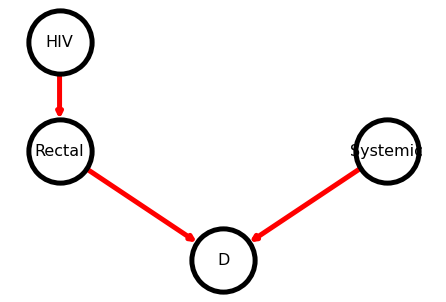

In [125]:
# Set node positions
pos = {0: (-1, 2), 1: (-1, 0.5), 2: (1, 0.5), 3: (0, -1)}

# Set options for graph looks
options = {
    "font_size": 16,
    "node_size": 4000,
    "node_color": "white",
    "edgecolors": "black",
    "edge_color": "red",
    "linewidths": 5,
    "width": 5,}
    
# Generate graph
n, d = bbn.to_nx_graph()
nx.draw(n, with_labels=True, labels=d, pos=pos, **options)

# Update margins and print the graph
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

Printing Marginal Probablities

In [126]:
def print_probs():
    for node in join_tree.get_bbn_nodes():
        potential = join_tree.get_bbn_potential(node)
        print("Node: ", node)
        print("Values:")
        print(potential)
        print('----------------')
        
# Use the above function to print marginal probabilities
print_probs()

Node:  1|Rectal|False,True
Values:
1=False|0.50620
1=True|0.49380
----------------
Node:  0|HIV|False,True
Values:
0=False|0.49664
0=True|0.50336
----------------
Node:  2|Systemic|None,Fever,Swollen Lymph Nodes,Muscle Aches and Pain
Values:
2=None|0.25528
2=Fever|0.24600
2=Swollen Lymph Nodes|0.24864
2=Muscle Aches and Pain|0.25008
----------------
Node:  3|D|Negative,Positive
Values:
3=Negative|0.36348
3=Positive|0.63652
----------------


To add evidence of events so that Probablity Distribution can be recalculated: 

In [127]:
def evidence(ev, nod, cat, val):
    ev = EvidenceBuilder().with_node(join_tree.get_bbn_node_by_name(nod)).with_evidence(cat, val).build()
    join_tree.set_observation(ev)
    
# Use above function to add evidence
#evidence('ev1', 'HIV', True, 1.0)

# Print marginal probabilities
#print_probs()

In [128]:
p_systemic_none= join_tree.get_bbn_potential(Systemic).entries[0].value
p_systemic_fever= join_tree.get_bbn_potential(Systemic).entries[1].value
p_systemic_swollen= join_tree.get_bbn_potential(Systemic).entries[2].value
p_systemic_muscle= join_tree.get_bbn_potential(Systemic).entries[3].value

In [129]:
print(join_tree.get_bbn_potential(Systemic))

2=None|0.25528
2=Fever|0.24600
2=Swollen Lymph Nodes|0.24864
2=Muscle Aches and Pain|0.25008


In [1]:
# p(disease | rectal, none)
evidence('ev1', 'Rectal', 'True', 1.0)
evidence('ev2', 'Systemic', 'None', 1.0)
p_rectal_yes_systemic_none = join_tree.get_bbn_potential(D).entries[1].value
join_tree.unobserve([Rectal, Systemic])

# p(disease | rectal, fever)
evidence('ev1', 'Rectal', 'True', 1.0)
evidence('ev2', 'Systemic', 'Fever', 1.0)
p_rectal_yes_systemic_fever = join_tree.get_bbn_potential(D).entries[1].value
join_tree.unobserve([Rectal, Systemic])

# p(disease | rectal, swollen)
evidence('ev1', 'Rectal', 'True', 1.0)
evidence('ev2', 'Systemic', 'Swollen Lymph Nodes', 1.0)
p_rectal_yes_systemic_swollen = join_tree.get_bbn_potential(D).entries[1].value
join_tree.unobserve([Rectal, Systemic])

# p(disease | rectal, muscle)
evidence('ev1', 'Rectal', 'True', 1.0)
evidence('ev2', 'Systemic', 'Muscle Aches and Pain', 1.0)
p_rectal_yes_systemic_muscle = join_tree.get_bbn_potential(D).entries[1].value
join_tree.unobserve([Rectal, Systemic])

# p(disease | ~rectal, none)
evidence('ev1', 'Rectal', 'False', 1.0)
evidence('ev2', 'Systemic', 'None', 1.0)
p_rectal_no_systemic_none = join_tree.get_bbn_potential(D).entries[0].value
join_tree.unobserve([Rectal, Systemic])

# p(disease | ~rectal, fever)
evidence('ev1', 'Rectal', 'False', 1.0)
evidence('ev2', 'Systemic', 'Fever', 1.0)
p_rectal_no_systemic_fever = join_tree.get_bbn_potential(D).entries[0].value
join_tree.unobserve([Rectal, Systemic])

# p(disease | ~rectal, swollen)
evidence('ev1', 'Rectal', 'False', 1.0)
evidence('ev2', 'Systemic', 'Swollen Lymph Nodes', 1.0)
p_rectal_no_systemic_swollen = join_tree.get_bbn_potential(D).entries[0].value
join_tree.unobserve([Rectal, Systemic])

# p(disease | ~rectal, muscle)
evidence('ev1', 'Rectal', 'False', 1.0)
evidence('ev2', 'Systemic', 'Muscle Aches and Pain', 1.0)
p_rectal_no_systemic_muscle = join_tree.get_bbn_potential(D).entries[0].value
join_tree.unobserve([Rectal, Systemic])


NameError: name 'evidence' is not defined

In [131]:
p_hiv_yes= join_tree.get_bbn_potential(HIV).entries[1].value
p_hiv_no= join_tree.get_bbn_potential(HIV).entries[0].value

In [132]:
# p(rectal | hiv)* p(hiv)
evidence('ev1', 'HIV', 'True', 1.0)
p_rectal_hiv_yes= join_tree.get_bbn_potential(Rectal).entries[1].value
join_tree.unobserve([HIV])

# p(rectal | ~hiv)* p(~hiv)
evidence('ev1', 'HIV', 'False', 1.0)
p_rectal_hiv_no= join_tree.get_bbn_potential(Rectal).entries[0].value
join_tree.unobserve([HIV])


In [133]:
p_rectal_yes= p_rectal_hiv_yes *p_hiv_yes + p_rectal_hiv_no * p_hiv_no

In [134]:
p_rectal_no= 1- p_rectal_yes

In [135]:
p_d_yes = p_rectal_yes_systemic_none * p_rectal_yes * p_systemic_none + p_rectal_yes_systemic_fever * p_rectal_yes * p_systemic_fever + p_rectal_yes_systemic_swollen * p_rectal_yes * p_systemic_swollen + p_rectal_yes_systemic_muscle * p_rectal_yes * p_systemic_muscle + p_rectal_no_systemic_none * p_rectal_no * p_systemic_none + p_rectal_no_systemic_fever * p_rectal_no * p_systemic_fever + p_rectal_no_systemic_swollen * p_rectal_no * p_systemic_swollen + p_rectal_no_systemic_muscle * p_rectal_no * p_systemic_muscle

In [136]:
p_d_no= 1-p_d_yes

In [137]:
p_d_yes

0.5677719803334321

In [138]:
p_d_no

0.4322280196665679

<h1>Result</h1>
Thus, Bayesian Belief Network has been performed on the MonkeyPox dataset. 